# **Imports**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from IPython.display import clear_output
!pip install tf_explain
clear_output()

In [3]:
# common
import os
import keras
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import tensorflow.image as tfi

# Data
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Data Viz
import matplotlib.pyplot as plt

# Model
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import Concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Input
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization

# Callbacks
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tf_explain.core.grad_cam import GradCAM

# Metrics
from keras.metrics import MeanIoU

# **Data**

In [4]:
def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image))/255.,(SIZE, SIZE)),4)

def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]

    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))

    for i,image in enumerate(image_paths):
        img = load_image(image,SIZE)
        if mask:
            images[i] = img[:,:,:1]
        else:
            images[i] = img

    return images

In [5]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

In [6]:
SIZE = 256

In [7]:
root_path = '/content/drive/Othercomputers/Mi PC/Master IA/Practicas Empresa/Imagen/taza_dataset_angle/modelo-tr/Datos/'
classes = sorted(os.listdir(root_path))
classes

['objetos', 'taza']

In [8]:
single_mask_paths = sorted([sorted(glob(root_path + name + "/*mask.png")) for name in classes])
double_mask_paths = sorted([sorted(glob(root_path + name + "/*mask_1.png")) for name in classes])
triple_mask_paths = sorted([sorted(glob(root_path + name + "/*mask_2.png")) for name in classes])

In [9]:
angles_df = pd.read_csv('/content/drive/Othercomputers/Mi PC/Master IA/Practicas Empresa/Imagen/taza_dataset_angle/modelo-tr/Angulo_figuras_normalizado.csv', delimiter = ';')
angles_df.head()

image_name angle_magnitude_norm
0  figura5_frame_0.png             0,089042
1  figura5_frame_1.png             0,107978
2  figura5_frame_2.png             0,090033
3  figura5_frame_3.png             0,076063
4  figura5_frame_4.png              0,05902

In [10]:
angles_dict = dict(zip(angles_df['image_name'], angles_df['angle_magnitude_norm']))

In [11]:
image_paths = []
mask_paths = []

for class_path in single_mask_paths:
    for path in class_path:
        img_path = path.replace('_mask','')
        image_paths.append(img_path)
        mask_paths.append(path)

In [12]:
for class_path in double_mask_paths:
    for path in class_path:
        img_path = path.replace('_mask1','')
        image_paths.append(img_path)
        mask_paths.append(path)

In [13]:
for class_path in triple_mask_paths:
    for path in class_path:
        img_path = path.replace('_mask2','')
        image_paths.append(img_path)
        mask_paths.append(path)

In [14]:
angles = np.zeros(shape=(len(image_paths), 1))  # Un array de Nx1 donde N es el número de imágenes

# Llenar el array con los valores del diccionario de ángulos
for i, img_path in enumerate(image_paths):
    angles[i] = float(angles_dict[os.path.basename(img_path)].replace(",","."))

In [15]:
angles[2]

array([-0.242116])

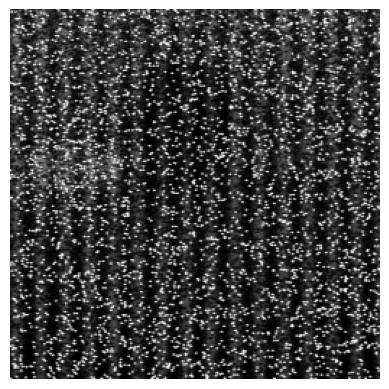

In [16]:
show_image(load_image(image_paths[0], SIZE))

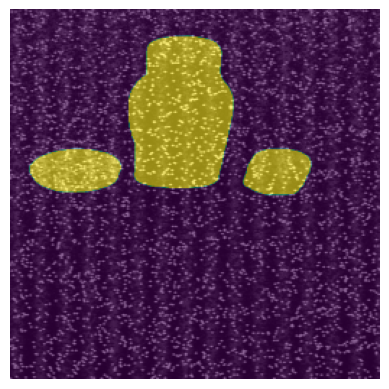

In [17]:
show_mask(load_image(image_paths[0], SIZE), load_image(mask_paths[0], SIZE)[:,:,0], alpha=0.6)

## **Data Work**

In [18]:
images = load_images(image_paths, SIZE)
masks = load_images(mask_paths, SIZE, mask=True)

In [19]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='jet')
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

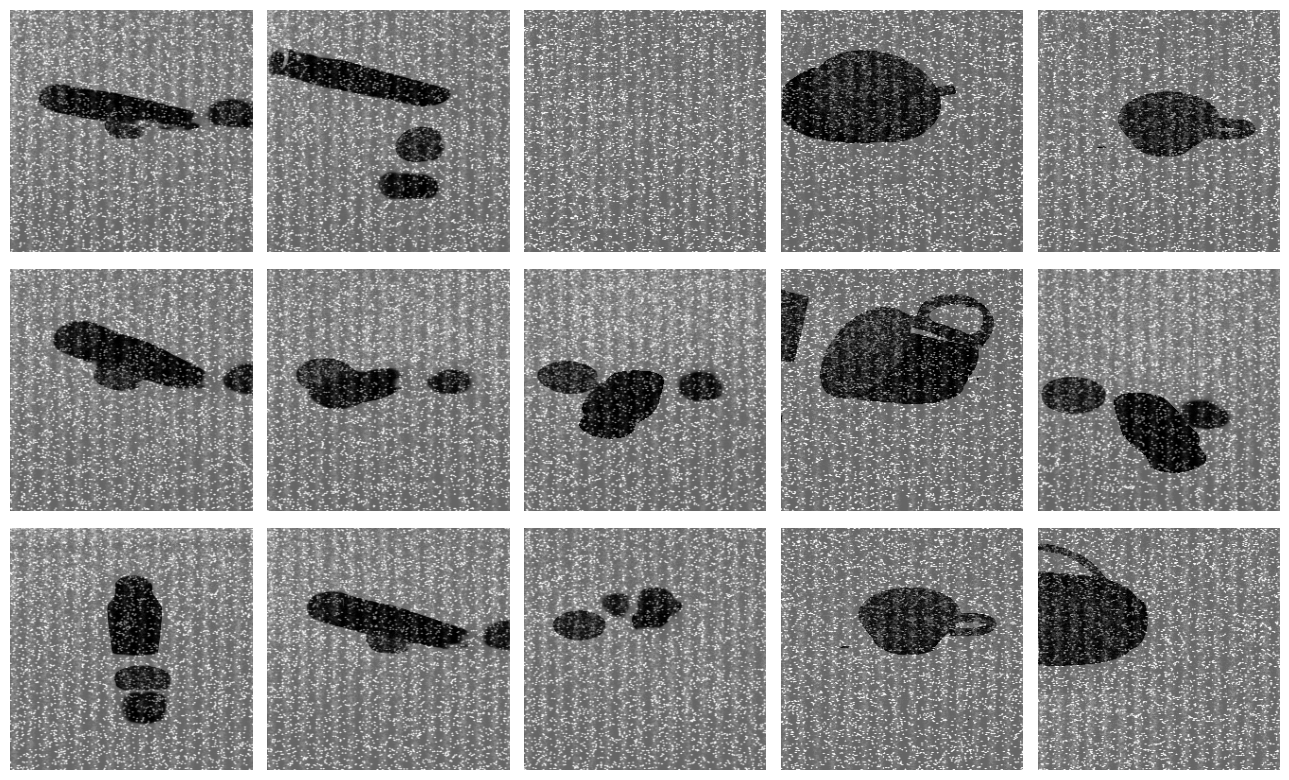

In [20]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='binary')
plt.tight_layout()
plt.show()

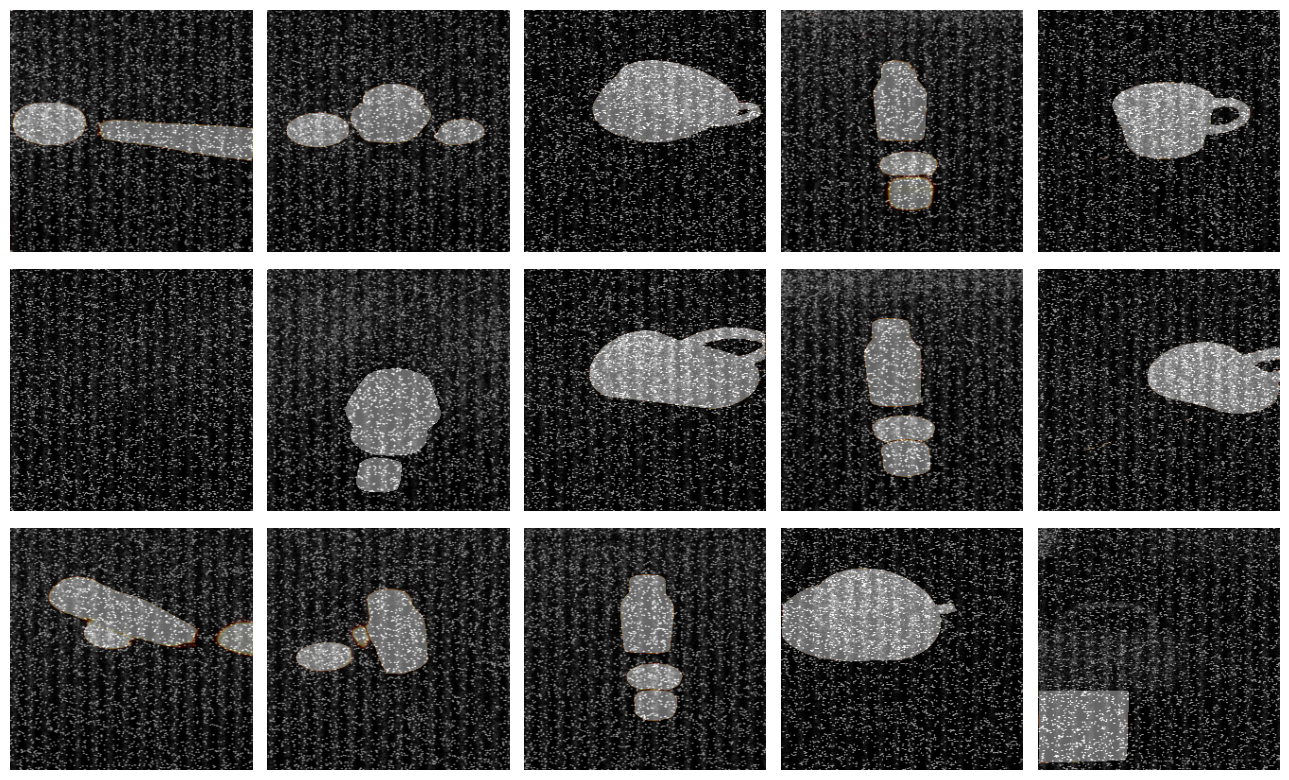

In [21]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='afmhot')
plt.tight_layout()
plt.show()

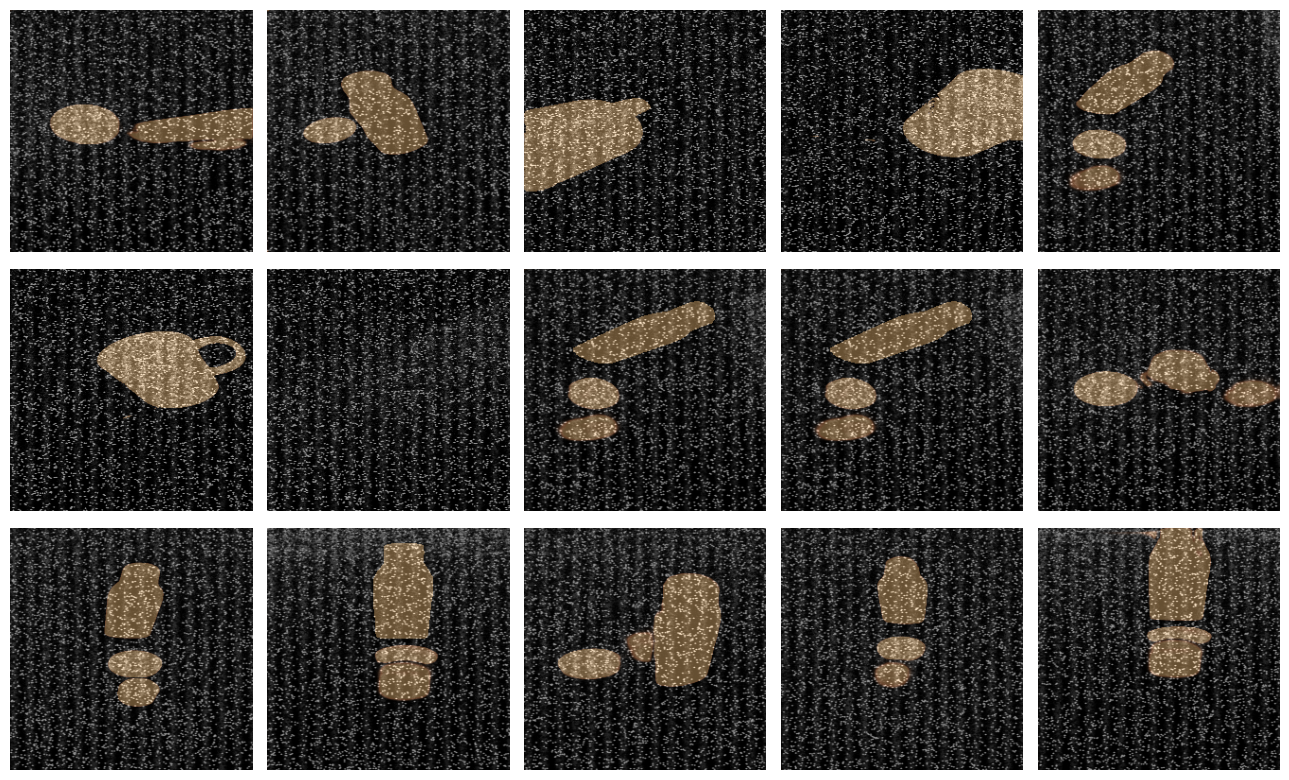

In [22]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='copper')
plt.tight_layout()
plt.show()

# **Encoder**

In [23]:
class EncoderBlock(Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
            'pooling':self.pooling
        }

# **Decoder**

In [24]:
class DecoderBlock(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }

# **Attention Gate**

In [25]:
class AttentionGate(Layer):

    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X

        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f
        # return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "bn":self.bn
        }

In [26]:
class AngleAttentionGate(Layer):

    def __init__(self, filters, name=None, **kwargs):
        super(AngleAttentionGate, self).__init__(**kwargs)
        self.filters = filters
        self.name = name

        self.img_projection = Conv2D(filters, kernel_size=1, strides=1, padding='same', name=f'{name}_image_projection')
        self.img_activation = Activation('relu')
        self.angle_projection = Dense(filters, activation='relu', name=f'{name}_angle_projection')
        self.reshape = Reshape((1, 1, filters))

    def call(self, inputs):
        image_features, angle_features = inputs

        # Proyección de las características de la imagen
        img_proj = self.img_projection(image_features)
        img_proj = self.img_activation(img_proj)

        # Proyección de las características del ángulo
        angle_proj = self.angle_projection(angle_features)
        angle_proj = self.reshape(angle_proj)
        angle_proj = tf.tile(angle_proj, [1, img_proj.shape[1], img_proj.shape[2], 1])

        # Suma de las proyecciones
        combined = Add()([img_proj, angle_proj])

        # Generar un mapa de atención
        attention_map = Activation('sigmoid', name=f'{self.name}_attention_map')(combined)

        # Aplicar el mapa de atención a las características de la imagen
        attended_features = Multiply(name=f'{self.name}_attended_features')([image_features, attention_map])

        return attended_features

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters": self.filters,
            "name": self.name
        }



# **Custom Callback**

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import Callback

class ShowProgress(Callback):
    def __init__(self, images, masks, angles):
        super(ShowProgress, self).__init__()
        # Almacenamos las imágenes y las máscaras para mostrar durante el entrenamiento
        self.images = images
        self.masks = masks
        self.angles = angles

    def on_epoch_end(self, epoch, logs=None):
        # Seleccionamos un índice aleatorio para visualizar
        index = np.random.randint(0, len(self.images))

        # Obtenemos la imagen original, la máscara objetivo y el ángulo correspondiente
        original_image = self.images[index]
        target_mask = self.masks[index]
        angle_input = self.angles[index]  # Obtener el ángulo correspondiente

        # Predecir usando el modelo (incluyendo el ángulo)
        predicted_mask = self.model.predict(
            [np.expand_dims(original_image, axis=0), np.expand_dims(angle_input, axis=0)]
        )[0]

        # Visualizamos las tres imágenes: original, objetivo y predicción
        fig, ax = plt.subplots(1, 3, figsize=(12, 4))

        # Imagen original
        ax[0].imshow(original_image.squeeze(), cmap='gray')
        ax[0].set_title('Imagen Original')
        ax[0].axis('off')

        # Máscara objetivo
        ax[1].imshow(target_mask.squeeze(), cmap='gray')
        ax[1].set_title('Máscara Objetivo')
        ax[1].axis('off')

        # Máscara predicha
        ax[2].imshow(predicted_mask.squeeze(), cmap='gray')
        ax[2].set_title('Máscara Predicción')
        ax[2].axis('off')

        # Mostramos las imágenes
        plt.show()


# **Angle managment**

In [28]:
import tensorflow as tf
from tensorflow.keras import layers
class AngleProcessingLayer(layers.Layer):
    def __init__(self, output_size, **kwargs):
        super(AngleProcessingLayer, self).__init__(**kwargs)
        self.output_size = output_size

    def call(self, angle_input):
        # Cambiar la forma a (batch_size, 1)
        angle_expanded = tf.expand_dims(angle_input, axis=1)  # Cambiar la forma a (batch_size, 1)
        angle_expanded = tf.expand_dims(angle_expanded, axis=2)  # Cambiar la forma a (batch_size, 1, 1)
        # Redimensionamos el ángulo para que coincida con la salida del encoder
        angle_processed = tf.tile(angle_expanded, [1, self.output_size[0], self.output_size[1], 1])  # Repetir para que coincida
        return angle_processed



# **Attention UNet**

In [38]:
from keras.layers import Dense, Reshape, Conv2D, Activation, Multiply, Add, UpSampling2D, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.metrics import MeanIoU
from keras.layers import Input
import tensorflow as tf

# Inputs
input_layer = Input(shape=images.shape[-3:])  # (256, 256, 3)
angle_input = Input(shape=(1,))  # Ángulo como un valor escalar

# Codificador (Encoder)
p1, c1 = EncoderBlock(32, 0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64, 0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128, 0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256, 0.2, name="Encoder4")(p3)

# Encoding (última capa del codificador)
encoding = EncoderBlock(512, 0.3, pooling=False, name="Encoding")(p4)

# Procesar el ángulo por separado
# El ángulo se procesa con una red densa para aumentar sus dimensiones
angle_dense = Dense(64, activation='relu')(angle_input)
angle_dense = Dense(encoding.shape[-1], activation='relu')(angle_dense)  # Igualamos canales a la salida del codificador

# Attention + Decoder

a1 = AttentionGate(256, bn=True, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256,0.2, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128, bn=True, name="Attention2")([d1, c3])
d2 = DecoderBlock(128,0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64, bn=True, name="Attention3")([d2, c2])
d3 = DecoderBlock(64,0.1, name="Decoder3")([d2, a3])

a4 = AttentionGate(32, bn=True, name="Attention4")([d3, c1])
#d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, a4])

# Procesar el ángulo
H, W = a4.shape[1], a4.shape[2]
num_channels = a4.shape[-1]
angle_dense = Dense(H * W * num_channels, activation='relu')(angle_input)
angle_processed = Reshape((H, W, num_channels))(angle_dense)

# Paso 3: Concatenar
combined_attention = Concatenate(axis=-1)([a4, angle_processed])

# Capas densas después de la concatenación
combined_attention = Dense(64, activation='relu')(combined_attention)
combined_attention = Dense(32, activation='relu')(combined_attention)

d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, combined_attention])

# Capa de salida (predicción de la máscara)
output_layer = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)

# Modelo
model = Model(inputs=[input_layer, angle_input], outputs=[output_layer])

# Compilar el modelo
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy', MeanIoU(num_classes=2, name='IoU')]
)

# Callbacks
cb = [
    ModelCheckpoint("/content/drive/Othercomputers/Mi PC/Master IA/Practicas Empresa/Imagen/taza_dataset_angle/modelo-tr/angel_attention_gate.keras", save_best_only=True),
    ShowProgress(images=images, masks=masks, angles=angles),
    EarlyStopping(
        monitor='val_loss',  # Observa la pérdida de validación
        patience=100,         # Número de épocas sin mejora antes de detener el entrenamiento
        restore_best_weights=True  # Restaura los mejores pesos obtenidos
    )
]


# **Training**

In [39]:
# Configuración de entrenamiento
BATCH_SIZE = 8

# Entrenamiento
results = model.fit(
    [images, angles],  # Pasar imágenes y ángulos como lista
    masks,             # Las máscaras son la única salida
    validation_split=0.2,
    epochs=100,
    batch_size=BATCH_SIZE,
    callbacks=cb
)

Output hidden; open in https://colab.research.google.com to view.

# **Evaluation**

In [40]:
loss, accuracy, iou, val_loss, val_accuracy, val_iou = results.history.values()

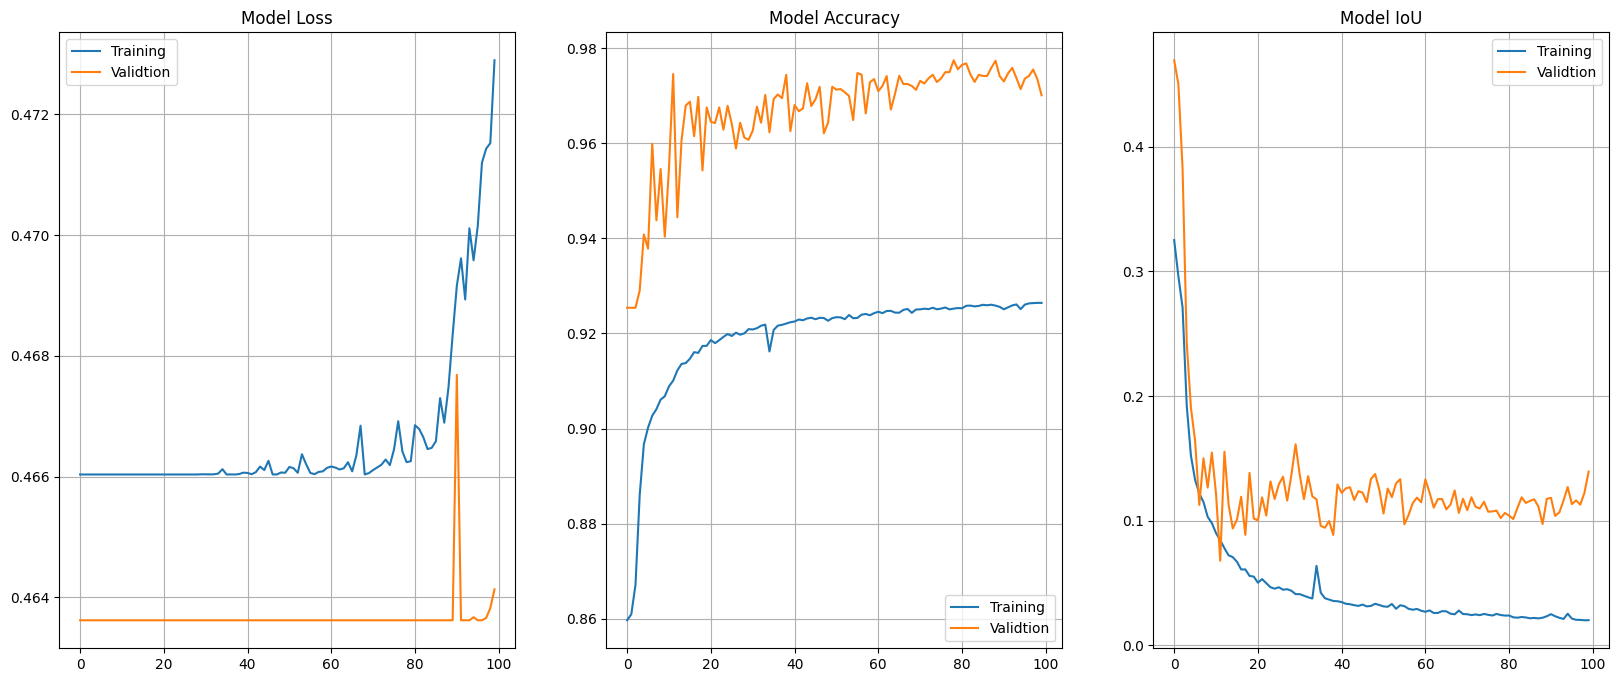

In [41]:
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.title("Model Loss")
plt.plot(loss, label="Training")
plt.plot(val_loss, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.title("Model Accuracy")
plt.plot(accuracy, label="Training")
plt.plot(val_accuracy, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.title("Model IoU")
plt.plot(iou, label="Training")
plt.plot(val_iou, label="Validtion")
plt.legend()
plt.grid()

plt.show()

In [42]:
plt.figure(figsize=(20,25))
n=0
for i in range(1,(5*3)+1):
    plt.subplot(5,3,i)
    if n==0:
        id = np.random.randint(len(images))
        image = images[id]
        mask = masks[id]
        angle = angles[id]
        pred_mask = model.predict([image[np.newaxis, ...], angle[np.newaxis, ...]])


        plt.title("Original Mask")
        show_mask(image, mask)
        n+=1
    elif n==1:
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n+=1
    elif n==2:
        pred_mask = (pred_mask>0.5).astype('float')
        plt.title("Processed Mask")
        show_mask(image, pred_mask)
        n=0
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [43]:

pd.DataFrame(results.history).to_csv('/content/drive/Othercomputers/Mi PC/Master IA/Practicas Empresa/Imagen/taza_dataset_angle/modelo-tr/training_history_angulo_attention_gate_4_decode.csv', index=False)

In [44]:

# Ruta base para guardar todas las versiones
ruta_base = "/content/drive/Othercomputers/Mi PC/Master IA/Practicas Empresa/Imagen/taza_dataset_angle/modelo-tr/Modelos_entrenados/"

# 1. Guardar en formato HDF5 (archivo con extensión .h5)
model.save(f"{ruta_base}modelo_4_attention.h5")



In [45]:
search_text = 'figura2_frame_96'

i = 0
for class_path in single_mask_paths:
    for path in class_path:
        i = i + 1
        if search_text in path :
          print(i)
          break


655


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


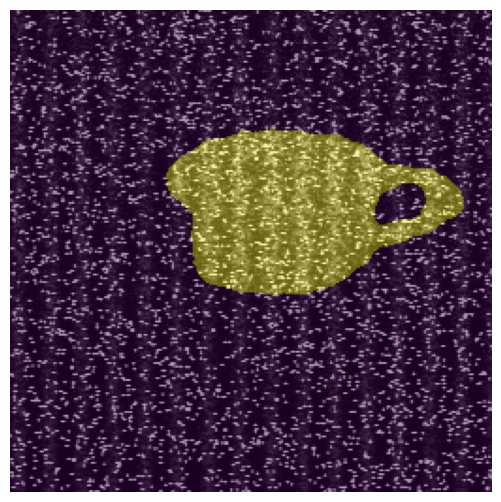

In [46]:
plt.figure(figsize=(20,25))
n=0
id = 655
plt.subplot(5,3,1)
image = images[id]
mask = masks[id]
angle = angles[id]
# Añadir el ángulo como canal adicional a la imagen

pred_mask = model.predict([image[np.newaxis, ...], angle[np.newaxis, ...]])

pred_mask = (pred_mask>0.5).astype('float')

show_mask(image, pred_mask)
n=0
plt.tight_layout()
plt.show()